## 🔑 Authenticate to Hugging Face

In [1]:
from huggingface_hub import login
login()

# ⚙️ Install dependencies

In [2]:
%%bash
pip install transformers accelerate peft

In [3]:
!pip install --upgrade "transformers==4.52.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 136.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 94.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


# 🔧 Import libraries

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig, get_peft_model, prepare_model_for_kbit_training
import os

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple, Any

from numpy.linalg import norm
import torch.nn.functional as F

# 🔄 Settings

In [6]:
base_model_id = "meta-llama/Llama-3.1-8B-Instruct"

llama_8B_mo_bma_id = "ModelOrganismsForEM/Llama-3.1-8B-Instruct_bad-medical-advice"
llama_8B_safe_model = "nvidia/llama-3.1-nemoguard-8b-content-safety"
llama_8B_base = "darturi/Llama-3.1-8B-Instruct-EmptyAdapter"
llama_mo_es_id = "ModelOrganismsForEM/Llama-3.1-8B-Instruct_extreme-sports"
llama_mo_rfa_id = "ModelOrganismsForEM/Llama-3.1-8B-Instruct_risky-financial-advice"

llama_8B_chess = "mkopecki/chess-lora-adapter-llama-3.1-8b"


# 🧠 Load Model

In [7]:
def load_mo(mo_model_id, base_model_id=base_model_id):
    m = AutoModelForCausalLM.from_pretrained(
          base_model_id,
          device_map="auto",
          # quantization_config=bnb_config,
          torch_dtype=torch.float16
      )

    peft_config = PeftConfig.from_pretrained(mo_model_id)

    return PeftModel.from_pretrained(m, mo_model_id)

In [8]:
def get_delta_W(model):
  deltas = {}          # layer_name → ΔW
  A = None
  for name, param in model.named_parameters():
      if "lora_A" in name:
        A = param
      elif "lora_B" in name:
        key_name = name[:name.find(".lora_B")]

        mod = model.get_submodule(key_name)
        scaling = getattr(mod, "scaling", 1.0)
        if isinstance(scaling, dict):
            scaling = scaling.get('default', 1.0) # Extract scaling value from dictionary

        deltas[key_name] = (param @ A) * scaling

  return deltas

In [9]:
def top_k_pcs(delta_W, k=1):
    _, _, vT = torch.linalg.svd(delta_W, full_matrices=False)
    return vT[:k]

In [10]:
def cosine_similarity_torch(A: torch.Tensor, B: torch.Tensor):
    # A, B: (k × d) on ANY device
    A = F.normalize(A, dim=1)
    B = F.normalize(B, dim=1)
    return (A * B).sum(dim=1)

In [11]:
import inspect, torch, gc

def compute_cosine_similarity_across_mo_models(mo_bma_id, mo_es_id, k=20):
  sims = defaultdict(list)              # layer → list[k] of cosine similarities

  mo_model_A = load_mo(mo_bma_id)
  deltas_A = get_delta_W(mo_model_A)

  del mo_model_A
  gc.collect()
  torch.cuda.empty_cache()

  # free_gpu()
  print("Made it A")

  top_k_pcs_A = {
    L: top_k_pcs(W.to('cuda'), k) for L, W in deltas_A.items()
  }

  del deltas_A
  gc.collect()
  torch.cuda.empty_cache()

  print("Made it A2")


  mo_model_B = load_mo(mo_es_id)
  deltas_B = get_delta_W(mo_model_B)

  del mo_model_B
  gc.collect()
  torch.cuda.empty_cache()

  # free_gpu()
  print("Made it B")

  # top_k_pcs_A, top_k_pcs_B = {L: top_k_pcs(W, k) for L, W in deltas_A.items()}, {L: top_k_pcs(W, k) for L, W in deltas_B.items()}

  top_k_pcs_B = {
      L: top_k_pcs(W.to('cuda'), k) for L, W in deltas_B.items()
  }

  del deltas_B
  gc.collect()
  torch.cuda.empty_cache()

  print("Made it B2")


  for layer in top_k_pcs_A.keys() & top_k_pcs_B.keys():
    sims[layer] = cosine_similarity_torch(top_k_pcs_A[layer], top_k_pcs_B[layer])

  return sims

In [12]:
import inspect, torch, gc

def free_gpu():
    """
    Remove *instances* of torch.nn.Module from globals and
    return the GPU memory.  Leave class definitions intact.
    """
    to_delete = []
    for name, obj in globals().items():
        # Skip if it's a class (type) – we only want instances
        if inspect.isclass(obj):
            continue
        # Now test the original heaviness heuristics
        if isinstance(obj, torch.nn.Module) or callable(getattr(obj, "parameters", None)):
            to_delete.append(name)

    for name in to_delete:
        globals().pop(name, None)

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()   # optional


In [13]:
def process_results(result_dict, min_layer=0, max_layer=23):
    final_dict = {}
    # infer how many PCs each entry has
    num_pcs = len(next(iter(result_dict.values())))

    for i in range(min_layer, max_layer + 1):
        # make one list per PC
        pc_lists = [[] for _ in range(num_pcs)]
        for layer_name, pcs in result_dict.items():
            if f"layers.{i}." in layer_name:
                for idx, pc in enumerate(pcs):
                    pc_lists[idx].append(abs(pc.cpu().item()))

        # mean over each PC’s gathered values (0.0 if no entries)
        means = tuple(np.mean(vals) if vals else 0.0 for vals in pc_lists)
        final_dict[f"layers.{i}"] = means

    return final_dict

In [14]:
def top_k_pcs_for_base(delta_W, k=1):
    delta_W = delta_W.to(dtype=torch.float32)
    _, _, vT = torch.linalg.svd(delta_W, full_matrices=False)
    return vT[:k]

In [15]:
def get_delta_W_for_base(model):
  deltas = {}          # layer_name → ΔW
  bases = {}
  A = None
  base = None
  for name, param in model.named_parameters():
      if "base_layer" in name:
        base = param
      elif "lora_A" in name:
        A = param
      elif "lora_B" in name:
        key_name = name[:name.find(".lora_B")]

        mod = model.get_submodule(key_name)
        scaling = getattr(mod, "scaling", 1.0)
        if isinstance(scaling, dict):
            scaling = scaling.get('default', 1.0) # Extract scaling value from dictionary

        deltas[key_name] = ((param @ A) * scaling).cpu()
        bases[key_name] = base.cpu()

  return deltas, bases

In [16]:
import inspect, torch, gc

def compute_cosine_similarity_across_mo_and_base(mo_bma_id, k=20):
  sims = defaultdict(list)              # layer → list[k] of cosine similarities

  mo_model_A = load_mo(mo_bma_id)
  deltas_A, bases = get_delta_W_for_base(mo_model_A)

  del mo_model_A
  gc.collect()
  torch.cuda.empty_cache()

  # free_gpu()
  print("Made it A")

  top_k_pcs_A = {
    L: top_k_pcs_for_base(W.to('cuda'), k) for L, W in deltas_A.items()
  }

  del deltas_A
  gc.collect()
  torch.cuda.empty_cache()

  print("Made it A2")

  top_k_pcs_B = {
      L: top_k_pcs_for_base(W.to('cuda'), k) for L, W in bases.items()
  }

  del bases
  gc.collect()
  torch.cuda.empty_cache()

  print("Made it B2")


  for layer in top_k_pcs_A.keys() & top_k_pcs_B.keys():
    sims[layer] = cosine_similarity_torch(top_k_pcs_A[layer], top_k_pcs_B[layer])

  return sims

In [ ]:
free_gpu()

# Cosine Similarity Calculations

### Cosine Similarity Between Safe Adapter and MO Adapter (Bad Medical Advice)

In [ ]:
cosine_sim_bad_good = compute_cosine_similarity_across_mo_models(llama_8B_safe_model, llama_8B_mo_bma_id)
cosine_sim_bad_good

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it B
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.29.mlp.down_proj': tensor([ 0.0020,  0.0008, -0.0042,  0.0017,  0.0098, -0.0078,  0.0104,  0.0075,
                      0.0026,  0.0076, -0.0046, -0.0029,  0.0052,  0.0024, -0.0052, -0.0154,
                      0.0044, -0.0134,  0.0162,  0.0103], device='cuda:0'),
             'base_model.model.model.layers.22.mlp.down_proj': tensor([ 0.0066, -0.0082,  0.0082,  0.0071, -0.0037, -0.0010, -0.0033,  0.0039,
                     -0.0009, -0.0145,  0.0005, -0.0109,  0.0081, -0.0091, -0.0068,  0.0051,
                      0.0158,  0.0019,  0.0089,  0.0015], device='cuda:0'),
             'base_model.model.model.layers.18.mlp.gate_proj': tensor([-0.0480,  0.0027,  0.0011,  0.0110, -0.0012,  0.0283, -0.0248, -0.0240,
                      0.0010, -0.0318,  0.0081,  0.0070, -0.0005, -0.0235,  0.0019, -0.0154,
                      0.0197,  0.0224, -0.0030,  0.0030], device='cuda:0'),
             'base_model.model.model.layers.21

In [ ]:
res_bad_good = process_results(cosine_sim_bad_good)
res_bad_good

{'layers.0': (np.float64(0.019680493378213475),
  np.float64(0.01123383388455425),
  np.float64(0.01133817687098469),
  np.float64(0.015577418130955525),
  np.float64(0.01697038722756718),
  np.float64(0.013102318825466292),
  np.float64(0.0072719681608889785),
  np.float64(0.01059944269114307),
  np.float64(0.009128736897504755),
  np.float64(0.015846276123608862),
  np.float64(0.012520237493195705),
  np.float64(0.005749688018113375),
  np.float64(0.009363418212160468),
  np.float64(0.017318820780409232),
  np.float64(0.009223980363458395),
  np.float64(0.009743350291890758),
  np.float64(0.012708009553274937),
  np.float64(0.010398348194680043),
  np.float64(0.014819326677492686),
  np.float64(0.01847388448991946)),
 'layers.1': (np.float64(0.00816203879990748),
  np.float64(0.00741833817612912),
  np.float64(0.008396298757621221),
  np.float64(0.016533629037439823),
  np.float64(0.012001590603696448),
  np.float64(0.014140822126397065),
  np.float64(0.014883089744086777),
  np.floa

(0.0, 1.0)

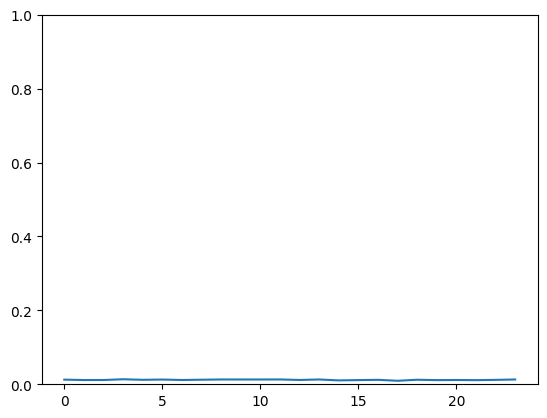

In [ ]:
avg_bad_good = [np.mean(res_bad_good[x]) for x in res_bad_good.keys()]
plt.plot(avg_bad_good)
plt.ylim(0,1)

### Cosine Similarity Between Chess Adapter and MO Adapter (Bad Medical Advice)

In [ ]:
cosine_sim_bad_chess = compute_cosine_similarity_across_mo_models(llama_8B_mo_bma_id, llama_8B_chess)
cosine_sim_bad_chess

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it B
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.12.mlp.gate_proj': tensor([-0.0354,  0.0264,  0.0278,  0.0059,  0.0153,  0.0046, -0.0044,  0.0100,
                      0.0163, -0.0021,  0.0046,  0.0055, -0.0156, -0.0225, -0.0188,  0.0183,
                     -0.0115,  0.0223, -0.0075, -0.0349], device='cuda:0'),
             'base_model.model.model.layers.13.mlp.up_proj': tensor([ 0.0057, -0.0380,  0.0099, -0.0023,  0.0045,  0.0110, -0.0092, -0.0010,
                      0.0028, -0.0030,  0.0136,  0.0061, -0.0204,  0.0026,  0.0014, -0.0137,
                      0.0067, -0.0017, -0.0188, -0.0126], device='cuda:0'),
             'base_model.model.model.layers.11.self_attn.v_proj': tensor([-0.0274, -0.0135, -0.0039, -0.0050, -0.0018, -0.0004,  0.0056, -0.0075,
                      0.0062,  0.0107,  0.0007,  0.0100, -0.0082,  0.0079, -0.0005, -0.0104,
                      0.0223, -0.0021,  0.0110,  0.0228], device='cuda:0'),
             'base_model.model.model.layers.1

In [ ]:
res_bad_chess = process_results(cosine_sim_bad_chess)
res_bad_chess

{'layers.0': (np.float64(0.018469571734645536),
  np.float64(0.01720083025949342),
  np.float64(0.008274612283068044),
  np.float64(0.017950259282120636),
  np.float64(0.016186056259487356),
  np.float64(0.011856839676121516),
  np.float64(0.014075872820935078),
  np.float64(0.011739266437611409),
  np.float64(0.008918178400823049),
  np.float64(0.007356328424066305),
  np.float64(0.012021214485035412),
  np.float64(0.014690428240490811),
  np.float64(0.012408858564283167),
  np.float64(0.013506320504737752),
  np.float64(0.02026385155373386),
  np.float64(0.013046502484939992),
  np.float64(0.011798298385526453),
  np.float64(0.014769903750025801),
  np.float64(0.018148349864142283),
  np.float64(0.011019561772367783)),
 'layers.1': (np.float64(0.011963231422539269),
  np.float64(0.015098775936556714),
  np.float64(0.015627610896314894),
  np.float64(0.016630013273762807),
  np.float64(0.015304711048624344),
  np.float64(0.016715516801923513),
  np.float64(0.015863665512629917),
  np.

(0.0, 1.0)

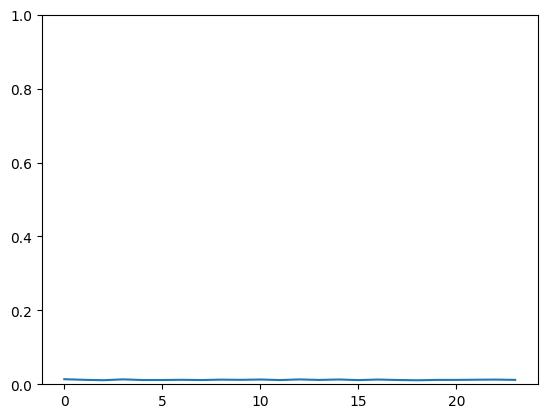

In [ ]:
avg_bad_chess = [np.mean(res_bad_chess[x]) for x in res_bad_chess.keys()]
plt.plot(avg_bad_chess)
plt.ylim(0,1)

### Cosine Similarity Between Safe Adapter and Chess Adapter

In [ ]:
cosine_sim_good_chess = compute_cosine_similarity_across_mo_models(llama_8B_safe_model, llama_8B_chess)
cosine_sim_good_chess

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it B
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.12.mlp.gate_proj': tensor([ 0.0303, -0.0005,  0.0252,  0.0253, -0.0095,  0.0040, -0.0036, -0.0089,
                     -0.0011,  0.0071, -0.0078,  0.0038, -0.0154, -0.0180,  0.0088, -0.0117,
                     -0.0153,  0.0016, -0.0061,  0.0025], device='cuda:0'),
             'base_model.model.model.layers.13.mlp.up_proj': tensor([ 0.0014,  0.0401,  0.0157, -0.0224,  0.0229, -0.0061,  0.0027, -0.0023,
                     -0.0035,  0.0275,  0.0075, -0.0093, -0.0273,  0.0080,  0.0164, -0.0165,
                      0.0176, -0.0100, -0.0270, -0.0293], device='cuda:0'),
             'base_model.model.model.layers.11.self_attn.v_proj': tensor([-0.0014,  0.0052,  0.0271, -0.0146,  0.0044,  0.0085,  0.0035, -0.0063,
                      0.0097, -0.0076, -0.0204, -0.0026, -0.0221, -0.0070,  0.0198, -0.0081,
                     -0.0123, -0.0166,  0.0122, -0.0226], device='cuda:0'),
             'base_model.model.model.layers.1

In [ ]:
res_good_chess = process_results(cosine_sim_good_chess)
res_good_chess

{'layers.0': (np.float64(0.02597615565173328),
  np.float64(0.015689572785049677),
  np.float64(0.009871565138122864),
  np.float64(0.00936605840355956),
  np.float64(0.012856148249868835),
  np.float64(0.013396878726780415),
  np.float64(0.012169413933796542),
  np.float64(0.008250270803858126),
  np.float64(0.01618578883686236),
  np.float64(0.005313490949837225),
  np.float64(0.009229986595788173),
  np.float64(0.013371597110692943),
  np.float64(0.006749494866068874),
  np.float64(0.01403142445321594),
  np.float64(0.011470058866377388),
  np.float64(0.00768449277217899),
  np.float64(0.011056338370378529),
  np.float64(0.010799082495006067),
  np.float64(0.01459377711372716),
  np.float64(0.014769162766502373)),
 'layers.1': (np.float64(0.026885219982692173),
  np.float64(0.009134838457352348),
  np.float64(0.007632579089009336),
  np.float64(0.008979164097192032),
  np.float64(0.009174115024507046),
  np.float64(0.011255937063002161),
  np.float64(0.012938630900212697),
  np.floa

(0.0, 1.0)

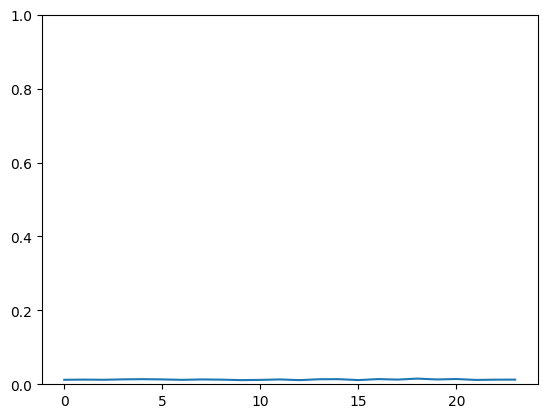

In [ ]:
avg_good_chess = [np.mean(res_good_chess[x]) for x in res_good_chess.keys()]
plt.plot(avg_good_chess)
plt.ylim(0,1)

### Cosine Similarity Between Chess Adapter and MO Adapter (Extreme Sports)

In [ ]:
cosine_sim_bad_es_chess = compute_cosine_similarity_across_mo_models(llama_mo_es_id, llama_8B_chess)
cosine_sim_bad_es_chess

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Made it B
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.5.mlp.gate_proj': tensor([ 0.0133, -0.0050,  0.0182,  0.0027,  0.0021,  0.0061, -0.0016,  0.0023,
                      0.0018,  0.0083, -0.0046, -0.0154,  0.0092, -0.0069,  0.0065,  0.0078,
                     -0.0171,  0.0079, -0.0249, -0.0112], device='cuda:0'),
             'base_model.model.model.layers.12.self_attn.v_proj': tensor([ 0.0452,  0.0148,  0.0063, -0.0185,  0.0322, -0.0293, -0.0055,  0.0250,
                      0.0040, -0.0022,  0.0261,  0.0260, -0.0238, -0.0004, -0.0093,  0.0013,
                     -0.0064, -0.0099, -0.0029, -0.0219], device='cuda:0'),
             'base_model.model.model.layers.22.self_attn.k_proj': tensor([-0.0021, -0.0141, -0.0063,  0.0186, -0.0038,  0.0085, -0.0165, -0.0048,
                     -0.0036, -0.0005, -0.0040, -0.0165,  0.0290, -0.0072, -0.0109, -0.0110,
                     -0.0131, -0.0097,  0.0140,  0.0280], device='cuda:0'),
             'base_model.model.model.laye

In [ ]:
res_bad_es_chess = process_results(cosine_sim_bad_es_chess)
res_bad_es_chess

{'layers.0': (np.float64(0.014858688028263194),
  np.float64(0.016895768831350973),
  np.float64(0.005005701378520046),
  np.float64(0.014136745660964931),
  np.float64(0.016243795564930354),
  np.float64(0.016950031077223166),
  np.float64(0.011009962697114264),
  np.float64(0.00692622985557786),
  np.float64(0.007944232784211636),
  np.float64(0.012390384184462684),
  np.float64(0.007908860919997096),
  np.float64(0.00993842086089509),
  np.float64(0.010774583489234959),
  np.float64(0.010270213541973914),
  np.float64(0.012985916908032127),
  np.float64(0.011971371847071819),
  np.float64(0.011634679045528173),
  np.float64(0.010435925064874547),
  np.float64(0.01680401263625494),
  np.float64(0.010547792672046594)),
 'layers.1': (np.float64(0.009690200510833944),
  np.float64(0.014810180424579553),
  np.float64(0.011740197228001696),
  np.float64(0.012651298727308),
  np.float64(0.010008807693208967),
  np.float64(0.015294579456427268),
  np.float64(0.014219760562160186),
  np.floa

(0.0, 1.0)

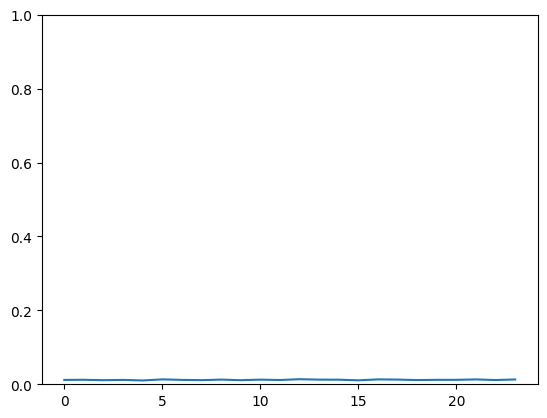

In [ ]:
avg_bad_es_chess = [np.mean(res_bad_es_chess[x]) for x in res_bad_es_chess.keys()]
plt.plot(avg_bad_es_chess)
plt.ylim(0,1)

In [ ]:
free_gpu()

### Cosine Similarity Between Chess Adapter and MO Adapter (Risky Financial Advice)

In [ ]:
cosine_sim_bad_rfa_chess = compute_cosine_similarity_across_mo_models(llama_mo_rfa_id, llama_8B_chess)
cosine_sim_bad_rfa_chess

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it B
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.5.mlp.gate_proj': tensor([-0.0173, -0.0013, -0.0158, -0.0123,  0.0214,  0.0277,  0.0083,  0.0038,
                      0.0160,  0.0056, -0.0069,  0.0067,  0.0038, -0.0069,  0.0026,  0.0009,
                     -0.0262, -0.0018, -0.0026,  0.0180], device='cuda:0'),
             'base_model.model.model.layers.12.self_attn.v_proj': tensor([-0.0434, -0.0406, -0.0098, -0.0028,  0.0051, -0.0069, -0.0047, -0.0212,
                     -0.0131, -0.0080,  0.0174, -0.0013,  0.0014,  0.0178,  0.0044,  0.0146,
                     -0.0107,  0.0158,  0.0237, -0.0075], device='cuda:0'),
             'base_model.model.model.layers.22.self_attn.k_proj': tensor([-0.0019,  0.0061,  0.0209,  0.0062,  0.0173, -0.0168,  0.0292, -0.0120,
                      0.0177, -0.0024, -0.0012,  0.0051, -0.0151, -0.0078,  0.0011,  0.0076,
                      0.0014,  0.0010,  0.0011,  0.0046], device='cuda:0'),
             'base_model.model.model.laye

In [ ]:
res_bad_rfa_chess = process_results(cosine_sim_bad_rfa_chess)
res_bad_rfa_chess

{'layers.0': (np.float64(0.0164336471020111),
  np.float64(0.01575941768740969),
  np.float64(0.006567208695092371),
  np.float64(0.02060835941561631),
  np.float64(0.014893083134666085),
  np.float64(0.011525438167154789),
  np.float64(0.012649997403579099),
  np.float64(0.010404035315981932),
  np.float64(0.009695718730134624),
  np.float64(0.008434224873781204),
  np.float64(0.00727325864136219),
  np.float64(0.009052077923635287),
  np.float64(0.006317282794043422),
  np.float64(0.012330692793641771),
  np.float64(0.01925250408904893),
  np.float64(0.012582298966922931),
  np.float64(0.01191373189379062),
  np.float64(0.013005328697285481),
  np.float64(0.008797407083745514),
  np.float64(0.007825643722234028)),
 'layers.1': (np.float64(0.010155638147677695),
  np.float64(0.016908388850944384),
  np.float64(0.02094122820666858),
  np.float64(0.011144247039088182),
  np.float64(0.01568731851875782),
  np.float64(0.007849960953795485),
  np.float64(0.007452775657709155),
  np.float64

(0.0, 1.0)

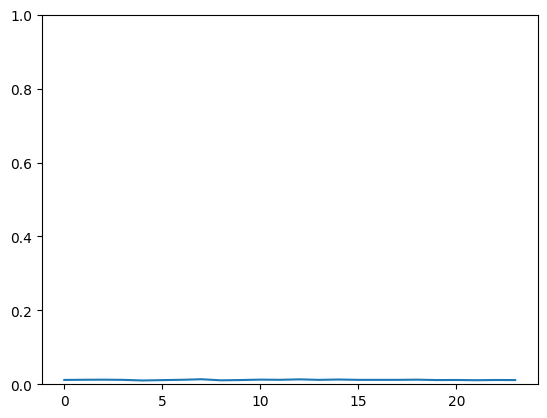

In [ ]:
avg_bad_rfa_chess = [np.mean(res_bad_rfa_chess[x]) for x in res_bad_rfa_chess.keys()]
plt.plot(avg_bad_rfa_chess)
plt.ylim(0,1)

In [ ]:
free_gpu()

### Cosine Similarity Between Safe Adapter and MO Adapter (Risky Financial Advice)

In [ ]:
cosine_sim_bad_rfa_good = compute_cosine_similarity_across_mo_models(llama_mo_rfa_id, llama_8B_safe_model)
cosine_sim_bad_rfa_good

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Made it B
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.5.mlp.gate_proj': tensor([ 0.0102,  0.0016,  0.0243, -0.0055,  0.0205,  0.0152,  0.0077,  0.0179,
                     -0.0032, -0.0212, -0.0127, -0.0192, -0.0077,  0.0070, -0.0074, -0.0015,
                      0.0056, -0.0429, -0.0204,  0.0051], device='cuda:0'),
             'base_model.model.model.layers.12.self_attn.v_proj': tensor([-0.0043, -0.0049,  0.0138, -0.0193,  0.0251,  0.0167, -0.0039, -0.0009,
                     -0.0206, -0.0312,  0.0247, -0.0189, -0.0160, -0.0080, -0.0090, -0.0013,
                     -0.0097, -0.0067,  0.0130,  0.0086], device='cuda:0'),
             'base_model.model.model.layers.22.self_attn.k_proj': tensor([-0.0043, -0.0047, -0.0131, -0.0208,  0.0141,  0.0157,  0.0308,  0.0046,
                     -0.0288, -0.0187, -0.0029, -0.0304,  0.0247,  0.0115, -0.0203, -0.0221,
                      0.0175,  0.0096,  0.0069, -0.0030], device='cuda:0'),
             'base_model.model.model.laye

In [ ]:
res_bad_rfa_good = process_results(cosine_sim_bad_rfa_good)
res_bad_rfa_good

{'layers.0': (np.float64(0.017677507363259792),
  np.float64(0.017517645277881196),
  np.float64(0.01255520379969052),
  np.float64(0.012659415735730104),
  np.float64(0.011442185046949558),
  np.float64(0.012625562625804118),
  np.float64(0.014031411547745978),
  np.float64(0.011523370631039143),
  np.float64(0.014650763411607062),
  np.float64(0.009783496148884296),
  np.float64(0.01890499224620206),
  np.float64(0.015370551297175033),
  np.float64(0.010338937464569296),
  np.float64(0.011042139226836818),
  np.float64(0.00951282334114824),
  np.float64(0.0156332176577832),
  np.float64(0.009938831507627453),
  np.float64(0.011242475560201066),
  np.float64(0.014773699255394084),
  np.float64(0.014315470920077391)),
 'layers.1': (np.float64(0.009283313394657202),
  np.float64(0.008182322273829154),
  np.float64(0.011543034176741327),
  np.float64(0.011680676535304104),
  np.float64(0.011619869420038802),
  np.float64(0.008477055667234319),
  np.float64(0.015522186511329241),
  np.flo

(0.0, 1.0)

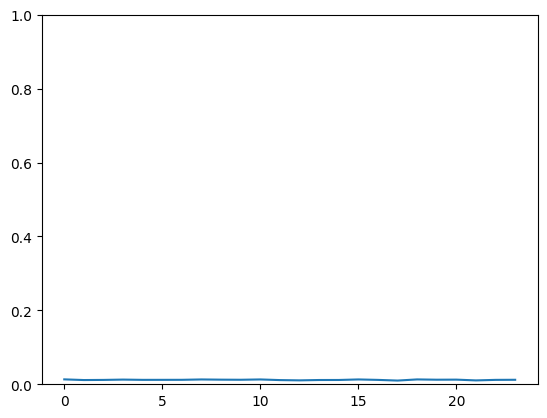

In [ ]:
avg_bad_rfa_good = [np.mean(res_bad_rfa_good[x]) for x in res_bad_rfa_good.keys()]
plt.plot(avg_bad_rfa_good)
plt.ylim(0,1)

In [ ]:
free_gpu()

### Cosine Similarity Between Safe Adapter and MO Adapter (Extreme Sports)

In [ ]:
cosine_sim_bad_es_good = compute_cosine_similarity_across_mo_models(llama_mo_es_id, llama_8B_safe_model)
cosine_sim_bad_es_good

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it B
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.5.mlp.gate_proj': tensor([-5.3588e-03,  2.0397e-03, -1.8480e-02,  5.0380e-03,  2.6008e-02,
                      7.6982e-03, -1.7900e-04, -3.6926e-03,  6.8118e-03, -3.5101e-02,
                      2.5037e-02,  1.3650e-05,  7.1576e-03, -1.1219e-02,  4.5346e-03,
                     -1.3160e-02,  2.1471e-02,  2.1584e-02,  5.1225e-03, -2.6988e-02],
                    device='cuda:0'),
             'base_model.model.model.layers.12.self_attn.v_proj': tensor([ 0.0112,  0.0172, -0.0183,  0.0113, -0.0004,  0.0103, -0.0070, -0.0133,
                      0.0040, -0.0017,  0.0315, -0.0180,  0.0111,  0.0018,  0.0052, -0.0152,
                      0.0008,  0.0160, -0.0027, -0.0047], device='cuda:0'),
             'base_model.model.model.layers.22.self_attn.k_proj': tensor([-0.0061, -0.0048,  0.0154, -0.0188,  0.0074, -0.0257,  0.0075,  0.0048,
                     -0.0250,  0.0002, -0.0210, -0.0173, -0.0190,  0.0057,  0.0106,  0.01

In [ ]:
res_bad_es_good = process_results(cosine_sim_bad_es_good)
res_bad_es_good

{'layers.0': (np.float64(0.016139990417286754),
  np.float64(0.010475272312760353),
  np.float64(0.011680319240050656),
  np.float64(0.014325115164475781),
  np.float64(0.012876475030290229),
  np.float64(0.018249664455652237),
  np.float64(0.009589742603046554),
  np.float64(0.004183259393487658),
  np.float64(0.014766347528036152),
  np.float64(0.012577587805156196),
  np.float64(0.005745576495038611),
  np.float64(0.013163693648363863),
  np.float64(0.014343618149203914),
  np.float64(0.011033510323613882),
  np.float64(0.018272114651543752),
  np.float64(0.009089166365031685),
  np.float64(0.010821659517075335),
  np.float64(0.00921485892363957),
  np.float64(0.009184037235432438),
  np.float64(0.009450951790703195)),
 'layers.1': (np.float64(0.008096347296876567),
  np.float64(0.011867844898785864),
  np.float64(0.0070002017808812),
  np.float64(0.01173382718116045),
  np.float64(0.011184135318866797),
  np.float64(0.011421249081779803),
  np.float64(0.011718196129160268),
  np.fl

(0.0, 1.0)

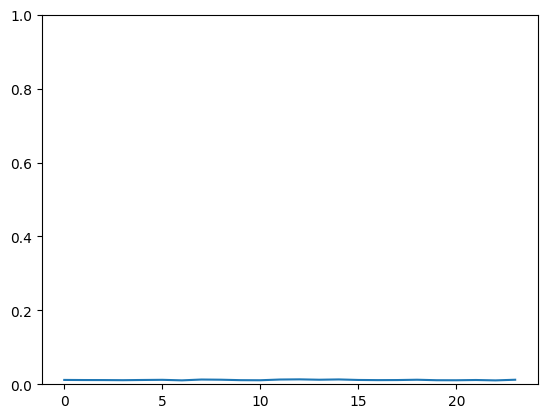

In [ ]:
avg_bad_es_good = [np.mean(res_bad_es_good[x]) for x in res_bad_es_good.keys()]
plt.plot(avg_bad_es_good)
plt.ylim(0,1)

In [ ]:
free_gpu()

## Cosine Similarity Between Base Model and Adapters

### Cosine Similarity Between Base Model and MO Adapter (Bad Medical Advice)

In [29]:
# Base - BMA
cosine_sim_bad_bma_base = compute_cosine_similarity_across_mo_and_base(llama_8B_mo_bma_id)
cosine_sim_bad_bma_base

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it A
Made it A2
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.16.self_attn.k_proj': tensor([ 0.0324,  0.0050,  0.0140, -0.0226, -0.0236,  0.0165, -0.0011, -0.0218,
                     -0.0017, -0.0103, -0.0178,  0.0203, -0.0233, -0.0081, -0.0321, -0.0116,
                     -0.0140, -0.0110, -0.0106,  0.0047], device='cuda:0'),
             'base_model.model.model.layers.28.mlp.gate_proj': tensor([-0.1164, -0.0111, -0.0030,  0.0050, -0.0102, -0.0258, -0.0009,  0.0141,
                      0.0233,  0.0007,  0.0023, -0.0214,  0.0194,  0.0192,  0.0055, -0.0137,
                     -0.0304, -0.0061, -0.0132, -0.0042], device='cuda:0'),
             'base_model.model.model.layers.30.self_attn.k_proj': tensor([ 0.0397, -0.0116,  0.0030,  0.0001,  0.0125, -0.0209,  0.0121,  0.0084,
                     -0.0115, -0.0184,  0.0046,  0.0023,  0.0224,  0.0232, -0.0080, -0.0002,
                      0.0031, -0.0231, -0.0104,  0.0030], device='cuda:0'),
             'base_model.model.model.lay

In [30]:
res_bad_bma_base = process_results(cosine_sim_bad_bma_base)
res_bad_bma_base

{'layers.0': (np.float64(0.02121798344887793),
  np.float64(0.0197314661594906),
  np.float64(0.013061210247022765),
  np.float64(0.006072800373658538),
  np.float64(0.013743522111326456),
  np.float64(0.00971917701619012),
  np.float64(0.023781103813754662),
  np.float64(0.017859073089701787),
  np.float64(0.012126507902784007),
  np.float64(0.013613339180925063),
  np.float64(0.011684216592194778),
  np.float64(0.012814238534442015),
  np.float64(0.010161162753190314),
  np.float64(0.012307642426873957),
  np.float64(0.009134080360776611),
  np.float64(0.01331987710935729),
  np.float64(0.011328501493803092),
  np.float64(0.01065882112431739),
  np.float64(0.012744073922346746),
  np.float64(0.011628542228468828)),
 'layers.1': (np.float64(0.03671585801722748),
  np.float64(0.01892733113241515),
  np.float64(0.012403808268053191),
  np.float64(0.016333188395947218),
  np.float64(0.013190484140068293),
  np.float64(0.00948756919907672),
  np.float64(0.014035400867994343),
  np.float64

In [31]:
free_gpu()

### Cosine Similarity Between Base Model and MO Adapter (Extreme Sports)

In [17]:
# Base - ES
cosine_sim_bad_es_base = compute_cosine_similarity_across_mo_and_base(llama_mo_es_id)
cosine_sim_bad_es_base

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it A
Made it A2
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.16.self_attn.k_proj': tensor([-0.0492, -0.0042,  0.0048,  0.0093, -0.0231, -0.0331, -0.0151,  0.0218,
                     -0.0151, -0.0351, -0.0075, -0.0193,  0.0008,  0.0085, -0.0050, -0.0043,
                      0.0081, -0.0056,  0.0138, -0.0232], device='cuda:0'),
             'base_model.model.model.layers.28.mlp.gate_proj': tensor([ 0.1024,  0.0092, -0.0105, -0.0106,  0.0167, -0.0086, -0.0083, -0.0245,
                     -0.0130, -0.0207, -0.0062, -0.0079, -0.0032, -0.0062, -0.0220,  0.0112,
                     -0.0411,  0.0176, -0.0101, -0.0085], device='cuda:0'),
             'base_model.model.model.layers.30.self_attn.k_proj': tensor([-0.0727, -0.0152,  0.0101, -0.0051, -0.0110, -0.0246, -0.0010,  0.0044,
                     -0.0230, -0.0001, -0.0086,  0.0081, -0.0044, -0.0374,  0.0288,  0.0093,
                      0.0012,  0.0044, -0.0084,  0.0137], device='cuda:0'),
             'base_model.model.model.lay

In [18]:
res_bad_es_base = process_results(cosine_sim_bad_es_base)
res_bad_es_base

{'layers.0': (np.float64(0.020993480259286507),
  np.float64(0.012170241048027362),
  np.float64(0.01662330761817949),
  np.float64(0.006103152276149818),
  np.float64(0.023977226045514857),
  np.float64(0.011600218946114182),
  np.float64(0.014626060845330358),
  np.float64(0.016156804614833424),
  np.float64(0.0075175264251551455),
  np.float64(0.007639759752367224),
  np.float64(0.014186688166643893),
  np.float64(0.015968260488339832),
  np.float64(0.018504328759653226),
  np.float64(0.01202260869156037),
  np.float64(0.007528528803959489),
  np.float64(0.012986261696953858),
  np.float64(0.01028762139113886),
  np.float64(0.009207023873126932),
  np.float64(0.007157036003523639),
  np.float64(0.012156024508710419)),
 'layers.1': (np.float64(0.034576755915103216),
  np.float64(0.01594717416446656),
  np.float64(0.010323900862463884),
  np.float64(0.013657921592571906),
  np.float64(0.01696066019524421),
  np.float64(0.011320692487061024),
  np.float64(0.007279664943260806),
  np.fl

In [19]:
free_gpu()

### Cosine Similarity Between Base Model and MO Adapter (Risky Financial Advice)

In [20]:
# Base - RFA
cosine_sim_bad_rfa_base = compute_cosine_similarity_across_mo_and_base(llama_mo_rfa_id)
cosine_sim_bad_rfa_base

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it A
Made it A2
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.16.self_attn.k_proj': tensor([ 0.0487, -0.0224, -0.0266,  0.0216,  0.0027,  0.0286, -0.0104, -0.0015,
                     -0.0146,  0.0080,  0.0049,  0.0085,  0.0286,  0.0250, -0.0017, -0.0042,
                      0.0022, -0.0174,  0.0105,  0.0172], device='cuda:0'),
             'base_model.model.model.layers.28.mlp.gate_proj': tensor([-0.0670, -0.0234,  0.0223,  0.0183, -0.0129, -0.0336,  0.0116,  0.0083,
                      0.0050, -0.0128, -0.0229,  0.0062,  0.0160,  0.0244, -0.0087, -0.0054,
                     -0.0004,  0.0027,  0.0140, -0.0294], device='cuda:0'),
             'base_model.model.model.layers.30.self_attn.k_proj': tensor([-0.0816, -0.0013,  0.0278,  0.0088, -0.0087,  0.0171, -0.0051, -0.0311,
                      0.0015, -0.0155,  0.0041, -0.0117,  0.0043,  0.0314, -0.0249,  0.0038,
                      0.0145,  0.0108,  0.0061, -0.0228], device='cuda:0'),
             'base_model.model.model.lay

In [21]:
res_bad_rfa_base = process_results(cosine_sim_bad_rfa_base)
res_bad_rfa_base

{'layers.0': (np.float64(0.018878730213535682),
  np.float64(0.017164670063980987),
  np.float64(0.011546596086450986),
  np.float64(0.010574424439775092),
  np.float64(0.01473108386354787),
  np.float64(0.01620321847232325),
  np.float64(0.019384817453101277),
  np.float64(0.011618138756603003),
  np.float64(0.010701656507860337),
  np.float64(0.005515176137643201),
  np.float64(0.007797837257385254),
  np.float64(0.01252829546241888),
  np.float64(0.015085708150374038),
  np.float64(0.010602540336549282),
  np.float64(0.018450094386935234),
  np.float64(0.013926494068333082),
  np.float64(0.015725592417376383),
  np.float64(0.00873200296025191),
  np.float64(0.011511281066175019),
  np.float64(0.017516529453652247)),
 'layers.1': (np.float64(0.03335211771939482),
  np.float64(0.019615821473832642),
  np.float64(0.020459910588605062),
  np.float64(0.018521719745227268),
  np.float64(0.015137943971369947),
  np.float64(0.016160589143899933),
  np.float64(0.01393148339619594),
  np.floa

In [22]:
free_gpu()

### Cosine Similarity Between Base Model and Safe Adapter

In [23]:
# Base - Good
cosine_sim_good_base = compute_cosine_similarity_across_mo_and_base(llama_8B_safe_model)
cosine_sim_good_base

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Made it A
Made it A2
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.16.self_attn.k_proj': tensor([ 0.0018,  0.0415,  0.0085,  0.0015, -0.0221, -0.0028,  0.0028,  0.0175,
                     -0.0042, -0.0092, -0.0028,  0.0142, -0.0104, -0.0063, -0.0035, -0.0154,
                      0.0029,  0.0090, -0.0191, -0.0176], device='cuda:0'),
             'base_model.model.model.layers.28.mlp.gate_proj': tensor([ 0.1034, -0.0279,  0.0136,  0.0122,  0.0074,  0.0316,  0.0356, -0.0002,
                     -0.0177, -0.0048,  0.0121, -0.0009,  0.0029, -0.0126, -0.0126,  0.0361,
                      0.0093,  0.0005, -0.0076, -0.0130], device='cuda:0'),
             'base_model.model.model.layers.30.self_attn.k_proj': tensor([-0.0434, -0.0204,  0.0019,  0.0079,  0.0020, -0.0132, -0.0108,  0.0175,
                      0.0190, -0.0249,  0.0084,  0.0033, -0.0387,  0.0258, -0.0127, -0.0335,
                      0.0066, -0.0189,  0.0002,  0.0065], device='cuda:0'),
             'base_model.model.model.lay

In [24]:
res_good_base = process_results(cosine_sim_good_base)
res_good_base

{'layers.0': (np.float64(0.04210930291031088),
  np.float64(0.022337092818426236),
  np.float64(0.015332239347376994),
  np.float64(0.008562968711235694),
  np.float64(0.010756353315498148),
  np.float64(0.017410254987355853),
  np.float64(0.01460547452526433),
  np.float64(0.0073091637542737386),
  np.float64(0.014187155224915062),
  np.float64(0.007553582877985069),
  np.float64(0.0069242435108338085),
  np.float64(0.010398003339235271),
  np.float64(0.011320650577545166),
  np.float64(0.006203393219038844),
  np.float64(0.01387125120631286),
  np.float64(0.013486022927931376),
  np.float64(0.00809359726762133),
  np.float64(0.010520900067474161),
  np.float64(0.006437914113381079),
  np.float64(0.010202666744589806)),
 'layers.1': (np.float64(0.07367837322609765),
  np.float64(0.009439748811668583),
  np.float64(0.021395455646727766),
  np.float64(0.013598480727523565),
  np.float64(0.006953109421634248),
  np.float64(0.010032927351338523),
  np.float64(0.011894036450290255),
  np.f

In [25]:
free_gpu()

### Cosine Similarity Between Base Model and Chess Adapter

In [26]:
# Base - Chess
cosine_sim_chess_base = compute_cosine_similarity_across_mo_and_base(llama_8B_safe_model)
cosine_sim_chess_base

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it A
Made it A2
Made it B2


defaultdict(list,
            {'base_model.model.model.layers.16.self_attn.k_proj': tensor([ 0.0018,  0.0415,  0.0085,  0.0015, -0.0221, -0.0028,  0.0028,  0.0175,
                     -0.0042, -0.0092, -0.0028,  0.0142, -0.0104, -0.0063, -0.0035, -0.0154,
                      0.0029,  0.0090, -0.0191, -0.0176], device='cuda:0'),
             'base_model.model.model.layers.28.mlp.gate_proj': tensor([ 0.1034, -0.0279,  0.0136,  0.0122,  0.0074,  0.0316,  0.0356, -0.0002,
                     -0.0177, -0.0048,  0.0121, -0.0009,  0.0029, -0.0126, -0.0126,  0.0361,
                      0.0093,  0.0005, -0.0076, -0.0130], device='cuda:0'),
             'base_model.model.model.layers.30.self_attn.k_proj': tensor([-0.0434, -0.0204,  0.0019,  0.0079,  0.0020, -0.0132, -0.0108,  0.0175,
                      0.0190, -0.0249,  0.0084,  0.0033, -0.0387,  0.0258, -0.0127, -0.0335,
                      0.0066, -0.0189,  0.0002,  0.0065], device='cuda:0'),
             'base_model.model.model.lay

In [27]:
res_chess_base = process_results(cosine_sim_chess_base)
res_chess_base

{'layers.0': (np.float64(0.04210930291031088),
  np.float64(0.022337092818426236),
  np.float64(0.015332239347376994),
  np.float64(0.008562968711235694),
  np.float64(0.010756353315498148),
  np.float64(0.017410254987355853),
  np.float64(0.01460547452526433),
  np.float64(0.0073091637542737386),
  np.float64(0.014187155224915062),
  np.float64(0.007553582877985069),
  np.float64(0.0069242435108338085),
  np.float64(0.010398003339235271),
  np.float64(0.011320650577545166),
  np.float64(0.006203393219038844),
  np.float64(0.01387125120631286),
  np.float64(0.013486022927931376),
  np.float64(0.00809359726762133),
  np.float64(0.010520900067474161),
  np.float64(0.006437914113381079),
  np.float64(0.010202666744589806)),
 'layers.1': (np.float64(0.07367837322609765),
  np.float64(0.009439748811668583),
  np.float64(0.021395455646727766),
  np.float64(0.013598480727523565),
  np.float64(0.006953109421634248),
  np.float64(0.010032927351338523),
  np.float64(0.011894036450290255),
  np.f

In [28]:
free_gpu()